In this challenge, wehave the code below to classify images of dogs and cats. We are using Tensorflow and Keras to create a convolutional neural network that correctly classifies images of cats and dogs at least 63% of the time.

The first code cell imports the required libraries. The second code cell downloads the data and sets key variables. The third cell is where we generate the cells.

The structure of the dataset files that are downloaded looks like this:
```
cats_and_dogs
|__ train:
    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:
    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]
```

We can tweak epochs and batch size if we want to effect the model, but it is not required.

In [2]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

We set each of the variables below. We create image generators for each of the three image data sets (train, validation, test). We use `ImageDataGenerator` to read / decode the images and convert them into floating point tensors. We use the `rescale` argument (and no other arguments for now) to rescale the tensors from values between 0 and 255 to values between 0 and 1.

For the `*_data_gen` variables, we use the `flow_from_directory` method. Pass in the batch size, directory, target size (`(IMG_HEIGHT, IMG_WIDTH)`), class mode, and anything else required. `test_data_gen` will be the trickiest one. For `test_data_gen`, we make sure to pass in `shuffle=False` to the `flow_from_directory` method. This will make sure the final predictions stay is in the order that our test expects.


After we run the code, the output will be like this:
```
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.
```

In [51]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(train_dir, batch_size=batch_size, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(validation_dir, batch_size=batch_size, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(
        '/content/cats_and_dogs', 
        classes=['test'],
        batch_size=batch_size,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode='binary',
        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


The `plotImages` function will be used a few times to plot images. It takes an array of images and a probabilities list, although the probabilities list is optional. Running the cell below will plot five random training images.

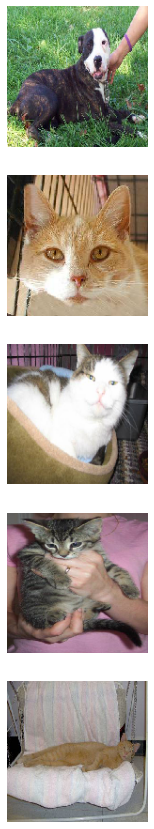

In [34]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

We now recreate the `train_image_generator` using `ImageDataGenerator`. 

Since there are a small number of training examples there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.

We add 4-6 random transformations as arguments to `ImageDataGenerator` and make sure to rescale the same as before.


In [41]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2
)


Found 2000 images belonging to 2 classes.


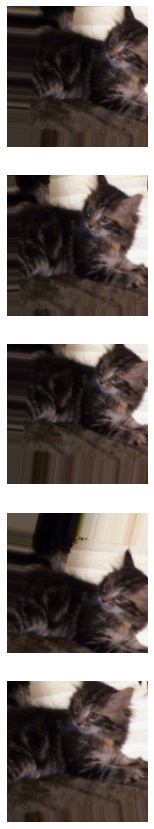

In [44]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In the cell below, we create a model for the neural network that outputs class probabilities. It uses the Keras Sequential model. It will probably involve a stack of Conv2D and MaxPooling2D layers and then a fully connected layer on top that is activated by a ReLU activation function.

It also Compiles the model passing the arguments to set the optimizer and loss. Also we pass in `metrics=['accuracy']` to view training and validation accuracy for each training epoch.

In [45]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 73, 73, 64)        0         
                                                                 
 flatten_4 (Flatten)         (None, 341056)            0         
                                                                 
 dense_8 (Dense)             (None, 128)               43655296  
                                                      

We use the `fit` method on our `model` to train the network and make sure to pass in arguments for `x`, `steps_per_epoch`, `epochs`, `validation_data`, and `validation_steps`.

In [46]:
history = model.fit(
        x=train_data_gen,
        steps_per_epoch=10,
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=total_val // batch_size)

Epoch 1/15
10/10 [==============================] - 15s 1s/step - loss: 8.4954 - accuracy: 0.4911 - val_loss: 0.8002 - val_accuracy: 0.5056
Epoch 2/15
10/10 [==============================] - 12s 1s/step - loss: 0.6993 - accuracy: 0.5164 - val_loss: 0.6958 - val_accuracy: 0.5045
Epoch 3/15
10/10 [==============================] - 12s 1s/step - loss: 0.6905 - accuracy: 0.5276 - val_loss: 0.6934 - val_accuracy: 0.5089
Epoch 4/15
10/10 [==============================] - 12s 1s/step - loss: 0.6869 - accuracy: 0.5349 - val_loss: 0.6761 - val_accuracy: 0.5145
Epoch 5/15
10/10 [==============================] - 12s 1s/step - loss: 0.6718 - accuracy: 0.5471 - val_loss: 0.6582 - val_accuracy: 0.5859
Epoch 6/15
10/10 [==============================] - 12s 1s/step - loss: 0.6642 - accuracy: 0.5893 - val_loss: 0.6442 - val_accuracy: 0.5636
Epoch 7/15
10/10 [==============================] - 12s 1s/step - loss: 0.6534 - accuracy: 0.6071 - val_loss: 0.6419 - val_accuracy: 0.6295
Epoch 8/15
10/10 [==

Run the next cell to visualize the accuracy and loss of the model.

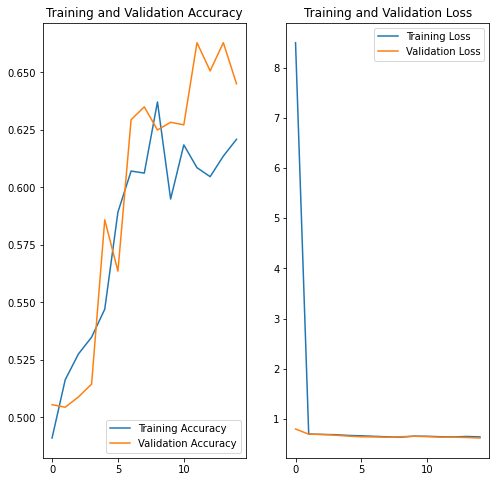

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Now we use the model to predict whether a brand new image is a cat or a dog.

In this final cell, we get the probability that each test image (from `test_data_gen`) is a dog or a cat. `probabilities` is a list of integers. 

Call the `plotImages` function and pass in the test images and the probabilities corresponding to each test image.

After we run the cell, we should see all 50 test images with a label showing the percentage sure that the image is a cat or a dog. The accuracy will correspond to the accuracy shown in the graph above (after running the previous cell). More training images could lead to a higher accuracy.

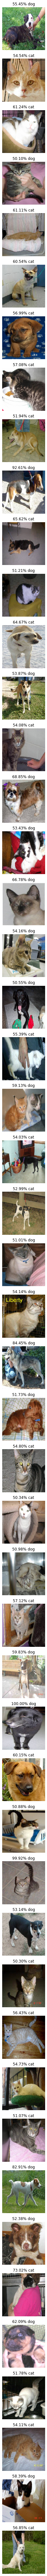

In [53]:
probabilities = model.predict(test_data_gen)
plotImages(sample_training_images[:50], probabilities)